This notebook where does the UV radiation come from in a disc, and how can we better weight the geometry when we compute the radiation force.

In [26]:
import matplotlib.pyplot as plt
import pyagn
import importlib
from pyagn import sed
importlib.reload(sed)
importlib.reload(pyagn)
import seaborn as sns
sns.set_context("talk")
import numpy as np
from astropy import units as u
from scipy import integrate
from pyagn import constants
import pysnooper

In [27]:
#bh = sed.SED(M = 1e6, mdot = 0.6, reprocessing = False)
#bh.plot_total_flux(1e26)

In [28]:
r_range = np.linspace(bh.corona_radius, bh.gravity_radius)
uv_fractions = bh.compute_uv_fractions(1e26)

In [29]:
M_range = [1e6, 1e8]
mdot_range = [0.05, 0.7]

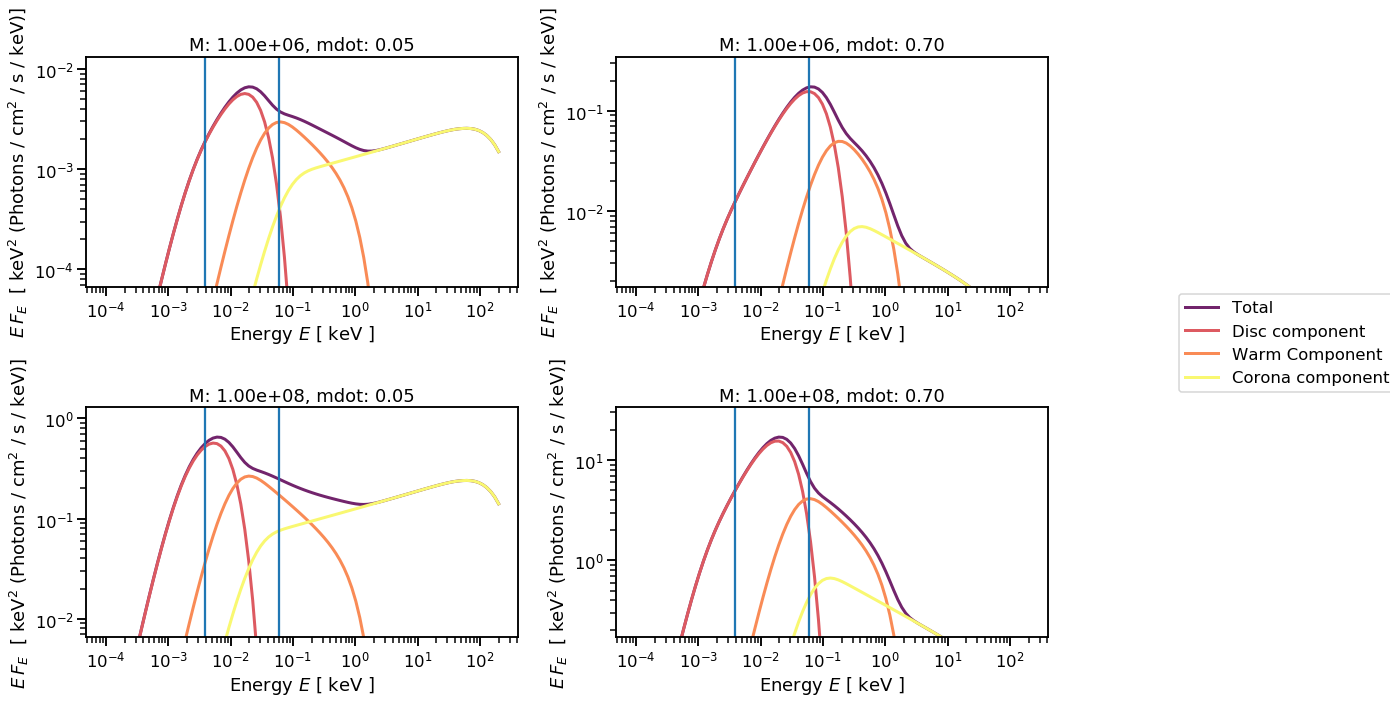

In [32]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
fraction_list = []
i = 0
for M in M_range:
    j = 0
    for mdot in mdot_range:
        bh = sed.SED(M=M, mdot=mdot)
        uv_fractions = bh.compute_uv_fractions(1e26)
        r_range = np.linspace(bh.corona_radius, bh.gravity_radius,200)
        data = {
            'M' : M,
            'mdot' : mdot,
            'frac' : uv_fractions,
            'r_range' : r_range,
        }
        fraction_list.append(data)
        
        
        axis = bh.plot_total_flux(1e26, ax[i][j])
        axis.set_title("M: %.2e, mdot: %.2f"%(M,mdot))
        ax[i][j].axvline(bh.ENERGY_UV_LOW_CUT_KEV)
        ax[i][j].axvline(bh.ENERGY_UV_HIGH_CUT_KEV)
        j += 1
    i += 1
handles, labels = ax[1][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor = (1.3,0.5))
plt.tight_layout()

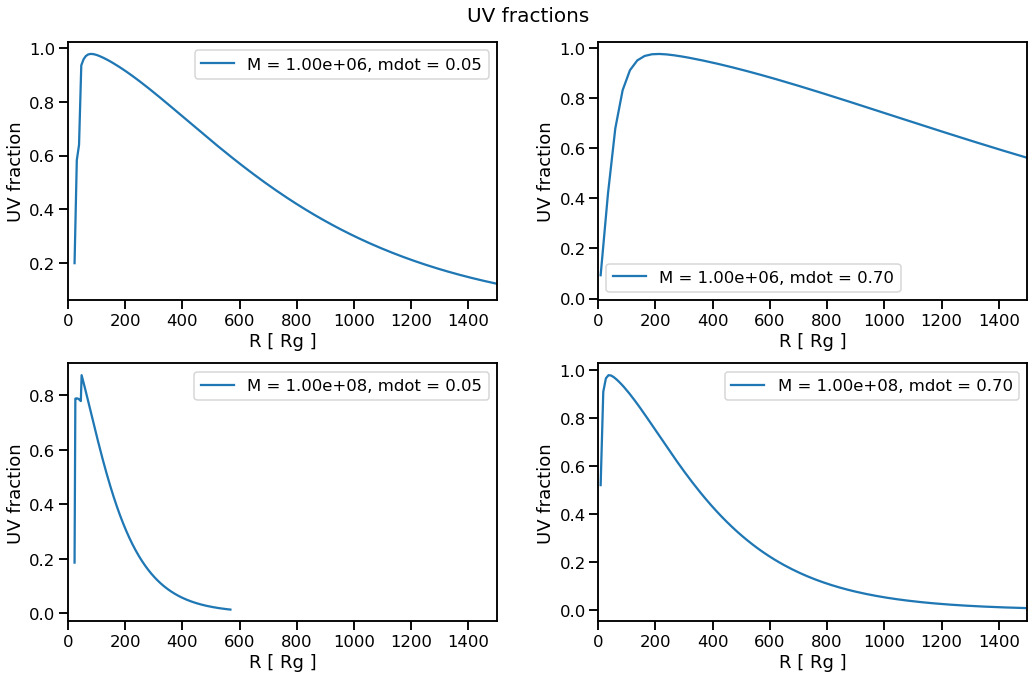

In [33]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
st = fig.suptitle("UV fractions", fontsize=20)
ax[0][0].plot(fraction_list[0]['r_range'], fraction_list[0]['frac'], label = "M = %.2e, mdot = %.2f"%(fraction_list[0]['M'], fraction_list[0]['mdot']))    
ax[0][1].plot(fraction_list[1]['r_range'], fraction_list[1]['frac'], label = "M = %.2e, mdot = %.2f"%(fraction_list[1]['M'], fraction_list[1]['mdot']))    
ax[1][0].plot(fraction_list[2]['r_range'], fraction_list[2]['frac'], label = "M = %.2e, mdot = %.2f"%(fraction_list[2]['M'], fraction_list[2]['mdot']))    
ax[1][1].plot(fraction_list[3]['r_range'], fraction_list[3]['frac'], label = "M = %.2e, mdot = %.2f"%(fraction_list[3]['M'], fraction_list[3]['mdot']))    

for axis in ax.flatten():
    axis.set_xlabel("R [ Rg ]")
    axis.set_ylabel("UV fraction")
    axis.set_xlim(0,1500)
    axis.legend()
    
plt.tight_layout()
# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.90)

In [7]:
distance = sed.convert_units(1 * u.Mpc, u.cm)

In [8]:
disc_r_range = np.geomspace(bh.corona_radius, bh.gravity_radius, 1000)
#dr = disc_r_range[1] - disc_r_range[0]
energy_range_erg = bh.ENERGY_RANGE_ERG
energy_range_kev = bh.ENERGY_RANGE_KEV
UV_KEV_CUT_LOW = 0.00387
UV_KEV_CUT_HIGH = 0.06
uv_kev_mask = (energy_range_kev > UV_KEV_CUT_LOW) & (energy_range_kev < UV_KEV_CUT_HIGH)
xray_kev_mask = energy_range_kev >= UV_KEV_CUT_HIGH
energy_range_uv_kev = energy_range_kev[uv_kev_mask]
energy_range_uv_erg = energy_range_erg[uv_kev_mask]
energy_range_xray_kev = energy_range_kev[xray_kev_mask]
energy_range_xray_erg = energy_range_erg[xray_kev_mask]

#uv_erg_cut_low = sed.convert_units(UV_KEV_CUT_LOW * u.keV, u.erg)
#uv_erg_cut_high = sed.convert_units(UV_KEV_CUT_HIGH * u.keV, u.erg)
#uv_erg_mask = (energy_range_erg > uv_erg_cut_low) & (energy_range_erg < uv_erg_cut_high)
#energy_range_uv_erg = energy_range_erg[uv_erg_mask]

In [9]:
distance = 1e26
#@pysnooper.snoop()
def compute_warm_flux(r, dr):
    flux_r = bh.warm_flux_r(r) # 1 / cm^2 / s
    #if (max(flux_r) == 0.):
    #    return np.zeros(len(bh.ENERGY_RANGE_KEV))
    ff = np.zeros(len(bh.ENERGY_RANGE_KEV))
    mask = flux_r > 0
    if len(flux_r[mask]) == 0:
        return ff
    energy_flux = integrate.trapz(x = bh.ENERGY_RANGE_ERG[mask], y = flux_r[mask])
    disk_lumin = 4 * np.pi * (bh.Rg)**2 * r * dr * bh.disk_radiance(r)
    disk_energy_flux = disk_lumin / ( 4 * np.pi * distance**2)
    ratio = disk_energy_flux / energy_flux
    energy_flux = ratio * flux_r[mask] * bh.ENERGY_RANGE_KEV[mask]
    ff[mask] = energy_flux
    return ff
    
def compute_disk_flux(r,dr):
    disk_energy_flux = np.pi * bh.disk_spectral_radiance_kev(bh.ENERGY_RANGE_KEV, r)
    disk_lumin = 4 * np.pi * (bh.Rg)**2 * r * dr * disk_energy_flux 
    disk_energy_flux = disk_lumin / ( 4 * np.pi * distance**2)
    disk_energy_flux = disk_energy_flux * bh.ENERGY_RANGE_KEV
    return disk_energy_flux
    


In [10]:
ratio_uv_list = []
ratio_xray_list = []
total_flux_list = []
dr_list = []
r_log_range = np.log10(disc_r_range)
dr_log = r_log_range[1] - r_log_range[0]
for i, r in enumerate(disc_r_range):
    
    dr = r * (10**dr_log - 1)
    dr_list.append(dr)
    warm_flux = compute_warm_flux(r, dr)
    disk_flux = compute_disk_flux(r,dr)
    
    total_flux = warm_flux + disk_flux
    mask = total_flux > 0
    uv_mask = mask & uv_kev_mask
    xray_mask = mask & xray_kev_mask
    
    total_flux_nonzero = total_flux[mask]
    total_flux_uv = total_flux[uv_mask]
    total_flux_xray = total_flux[xray_mask]
    
    #ratio_uv = sum(total_flux_uv) / sum(total_flux)
    total_flux_sum = integrate.simps(x=bh.ENERGY_RANGE_KEV, y = total_flux / bh.ENERGY_RANGE_KEV)
    total_flux_uv = integrate.simps(x=bh.ENERGY_RANGE_KEV[uv_mask], y = total_flux_uv / bh.ENERGY_RANGE_KEV[uv_mask])
    total_flux_xray = integrate.simps(x=bh.ENERGY_RANGE_KEV[xray_mask], y = total_flux_xray / bh.ENERGY_RANGE_KEV[xray_mask])
    
    ratio_uv = total_flux_uv / total_flux_sum 
    ratio_xray = total_flux_xray / total_flux_sum 
    
    ratio_uv_list.append(ratio_uv)
    ratio_xray_list.append(ratio_xray)
    total_flux_list.append(total_flux_sum)

TypeError: warm_flux_r() missing 2 required positional arguments: 'dr' and 'distance'

In [ ]:
bh.bolometric_luminosity

In [ ]:
plt.plot(disc_r_range, ratio_uv_list)
plt.plot(disc_r_range, ratio_xray_list)
#plt.ylim(0.01,1)

In [ ]:
uv_ratios = np.array(ratio_uv_list)
xray_ratios = np.array(ratio_xray_list)

In [ ]:
corona_flux = integrate.simps(x = bh.ENERGY_RANGE_KEV, y = bh.corona_flux(distance) / bh.ENERGY_RANGE_KEV)

In [ ]:
tot_flux = integrate.simps(x = disc_r_range, y = total_flux_list / np.array(dr_list))
uv_flux = integrate.simps(x = disc_r_range, y = total_flux_list * uv_ratios / np.array(dr_list))
xray_flux = integrate.simps(x = disc_r_range, y = total_flux_list * xray_ratios / np.array(dr_list))
#uv_flux = sum(uv_ratios * total_flux_list)

In [ ]:
total_flux = tot_flux + corona_flux
uv_flux / total_flux

In [ ]:
xray_flux / total_flux

In [ ]:
bh.uv_fraction

In [ ]:
bh.xray_fraction